## Loading a model and predicting patients

Each of the trained models can be restored from their checkpoints and used for evaluation or prediction, thanks to `tf.estimator.Estimator` API.

This can be done with `main.py` using the following call:
```
python src/main.py -model_dir models/base_model -mode predict - pred_ix 0 1 2 3 4 5 6 7 8 9
```

Alternatively predicting only the 2nd and 7th patient is as simple as:
```
python src/main.py -model_dir models/base_model -mode predict - pred_ix 1 6
```

## Examining predictions

Here we already predicted all patients with all 3 models (`base_model`, `base_model_no_bn`, `deeper_model`) both on the original test scans and the resized (128 x 128) ones.

We'll load some of these and visualise them next to the ground truth.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()

from src.data_utils import Dataset
from src.input_fn import input_fn

## Load predictions from different models

In [2]:
# model dirs
base_model_dir = '../models/base_model/'
deeper_model_dir = '../models/deeper_model/'

# predictions of base model on resized test set (128x128)
preds_file = open(os.path.join(base_model_dir, 'preds.npy'),'rb')
bm_resized_preds = pickle.load(preds_file)

# predictions of deeper model on resized test set (128x128)
preds_file = open(os.path.join(deeper_model_dir, 'preds.npy'),'rb')
dm_resized_preds = pickle.load(preds_file)

## Reuse src.data_utils.Dataset to visualise

We can load a saved test dataset and use its plotting code to visualise truth vs prediction.

By replacing the scans in each patient with the original ground truth segmentation (left) and the original segmentation array with the predictions, we can easily plot anyone's prediction vs real segmentation.

### Check predictions from base model

In [3]:
preds = bm_resized_preds
test_dataset_resized = Dataset.load_dataset('../data/processed/test_dataset_resized.pckl')
for i, p in enumerate(test_dataset_resized.patients.values()):
    # restrict plots to middle section, i.e. interesting part
    p.scans = preds[i]['truth'][9:18]
    p.seg = preds[i]['classes'][9:18]
    p.preprocessed = False

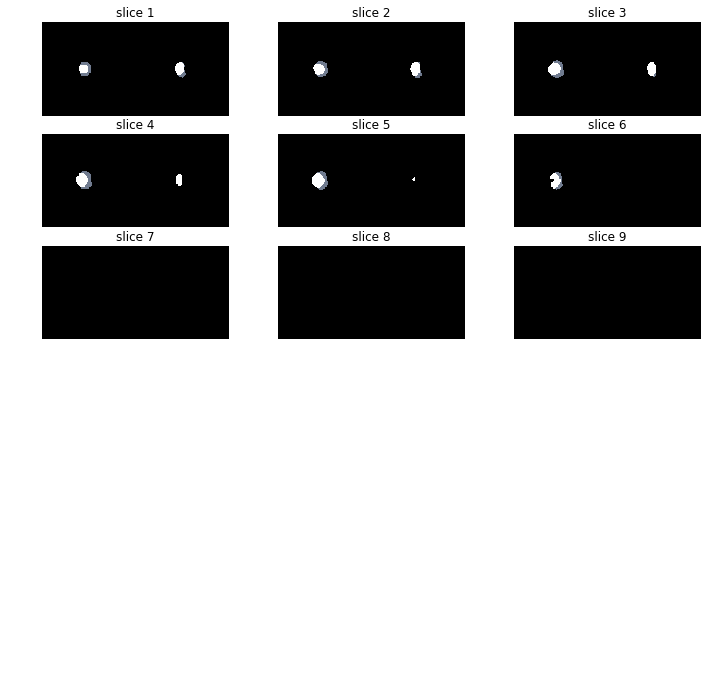

In [4]:
test_dataset_resized.patients[test_dataset_resized.patient_ids[3]].patient_tile_scans()

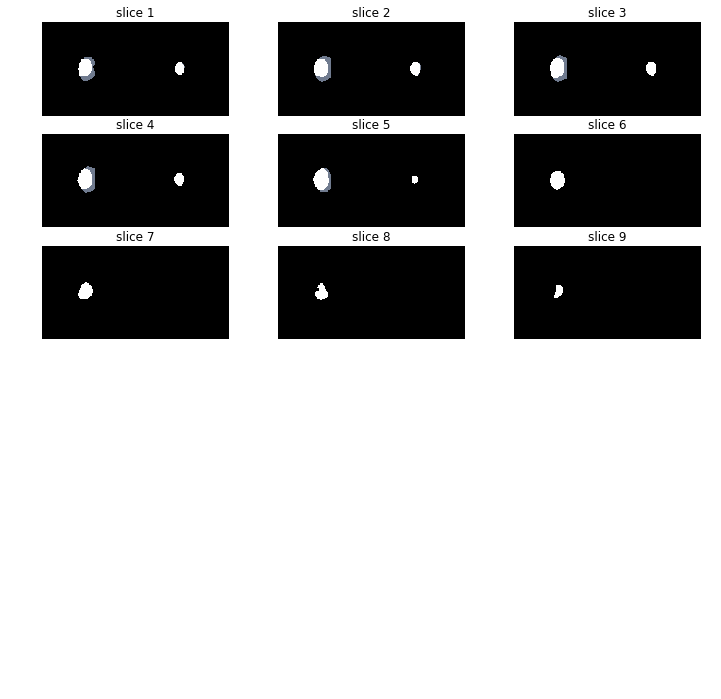

In [5]:
test_dataset_resized.patients[test_dataset_resized.patient_ids[7]].patient_tile_scans()

### Check predictions from deeper model

In [6]:
preds = dm_resized_preds
test_dataset_resized = Dataset.load_dataset('../data/processed/test_dataset_resized.pckl')
for i, p in enumerate(test_dataset_resized.patients.values()):
    # restrict plots to middle section, i.e. interesting part
    p.scans = preds[i]['truth'][9:18]
    p.seg = preds[i]['classes'][9:18]
    p.preprocessed = False

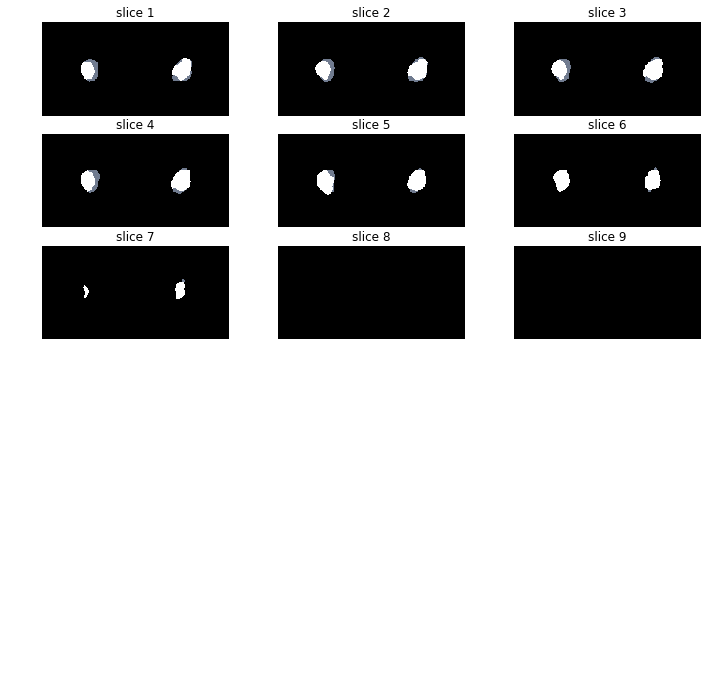

In [7]:
test_dataset_resized.patients[test_dataset_resized.patient_ids[7]].patient_tile_scans()

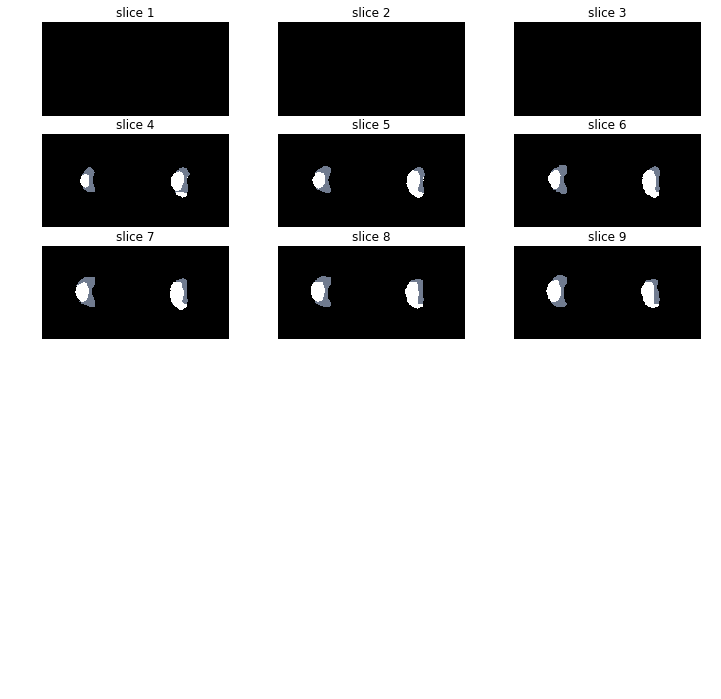

In [8]:
test_dataset_resized.patients[test_dataset_resized.patient_ids[9]].patient_tile_scans()